## Advanced Lane Finding and Vechicile Detection Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

* Analyze Vechicle data
* Feature extraction
* Training Classifier
* scroll window to analysis image

---


# Data Exploration

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import random
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import time
from scipy.ndimage.measurements import label

#from skimage.feature import hog
#from skimage import color, exposure
# images are divided up into vehicles and non-vehicles

def load_files(start_dir,files,suffix):
    for dr,_,_ in os.walk(start_dir):
        files.extend(glob.glob(os.path.join(dr,suffix)))        
    return files
def load_data(start_path,suffix='*.png'):
    files=[]
    imgs=[]
    suffix='*.png'
    files=load_files(start_path,files,suffix)
    for filename in files:
        imgs.append(cv2.imread(filename))
    return files,imgs

def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    
    test_image = car_list[0]
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = test_image.shape 
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_image.dtype
    # Return data_dict
    
    return data_dict

def display_image(img, title):
    plt.title(title)
    plt.imshow(img)
    plt.show()


In [2]:
def load_dataset():
    cars,cars_images=load_data('data/vehicles')
    notcars,notcars_images=load_data('data/non-vehicles')
    print(len(cars_images))
    print(len(notcars_images))
    return cars,cars_images,notcars,notcars_images

#load_data('data/vehicles_smallset/cars1','.jpeg')
#load_data('data/non-vehicles_smallset/notcars1','.jpeg')

In [3]:
cars,cars_images,notcars,notcars_images=load_dataset()
data_info=data_look(cars_images,notcars_images)

8792
8968


# Feature Extraction

## Color Histogram


In [4]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.cross_validation import train_test_split

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


/Users/hubing/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# HOG Features


In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

## Feature Combination


In [6]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:

        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        img = mpimg.imread(file)
        img_features=single_img_features(img, color_space, spatial_size,
                                         hist_bins, orient,pix_per_cell, cell_per_block, hog_channel,
                                         spatial_feat, hist_feat, hog_feat)
        img_features_inv=single_img_features(np.fliplr(img), color_space, spatial_size,
                                             hist_bins, orient,pix_per_cell, cell_per_block, hog_channel,
                                             spatial_feat, hist_feat, hog_feat)

        features.append(img_features)
        features.append(img_features_inv)
    # Return list of feature vectors
    return features

In [7]:
sample_size = 1700
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler

X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using the folowing parameters')
print('  orientations:',orient)
print('  pixels per cell:',pix_per_cell)
print('  cells per block:',cell_per_block )
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

/Users/hubing/anaconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using the folowing parameters
  orientations: 9
  pixels per cell: 8
  cells per block: 2
0.97 Seconds to train SVC...
Test Accuracy of SVC =  0.9831


In [8]:
import pickle
data = {
        'scaler': X_scaler,
        'classifier': svc
        }

with open('classifier.p', 'wb') as f:
    pickle.dump(data, f)

# Car Detection

In [9]:
def stride_windows(img, win_size, num_win_x, y_top):
    x_right = img.shape[1] - win_size
    x_offset=500
    x_stride = int(round((x_right-x_offset) / (num_win_x-1)))
    windows = []
    for xs in range(num_win_x-1):
        windows.append(((xs*x_stride+x_offset, y_top), (xs*x_stride+win_size+x_offset, y_top+win_size)))
    # Make sure that the last window is pushed all the way to the edge
    windows.append(((x_right, y_top),(img.shape[1], y_top+win_size)))
    return windows

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    colors = [(0, 0, 255), (0, 255, 0)]
    for idx, bbox in enumerate(bboxes):
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], colors[idx%2], thick)
    # Return the image copy with boxes drawn
    return imcopy

def form_windows(image):
    windows = []
    coords = [
        (75, 40, 400),
        (120, 30, 390),
        (200, 10, 390),
        (220, 30, 350),
    ]
    for win_size, num_win_x, y_top in coords:
        windows.extend(stride_windows(image, win_size, num_win_x, y_top))
    return windows



# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list

    for window in windows:
        #img = img.astype(np.float32)/255

        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
     
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

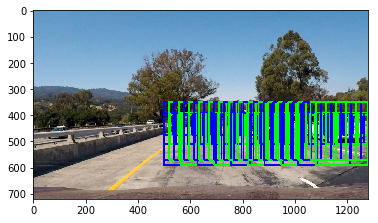

In [10]:
imagename = 'test_images/test1.jpg'

img = mpimg.imread(imagename)
windows = form_windows(img)
window_img = draw_boxes(img, windows, color=(0, 0, 255), thick=6) 
        # Convert to uint8 so that imshow displays properly
plt.imshow(window_img.astype(np.uint8))

plt.show()

In [11]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def get_labels(heatmap_img):
    return label(heatmap_img)

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img


/Users/hubing/anaconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
2


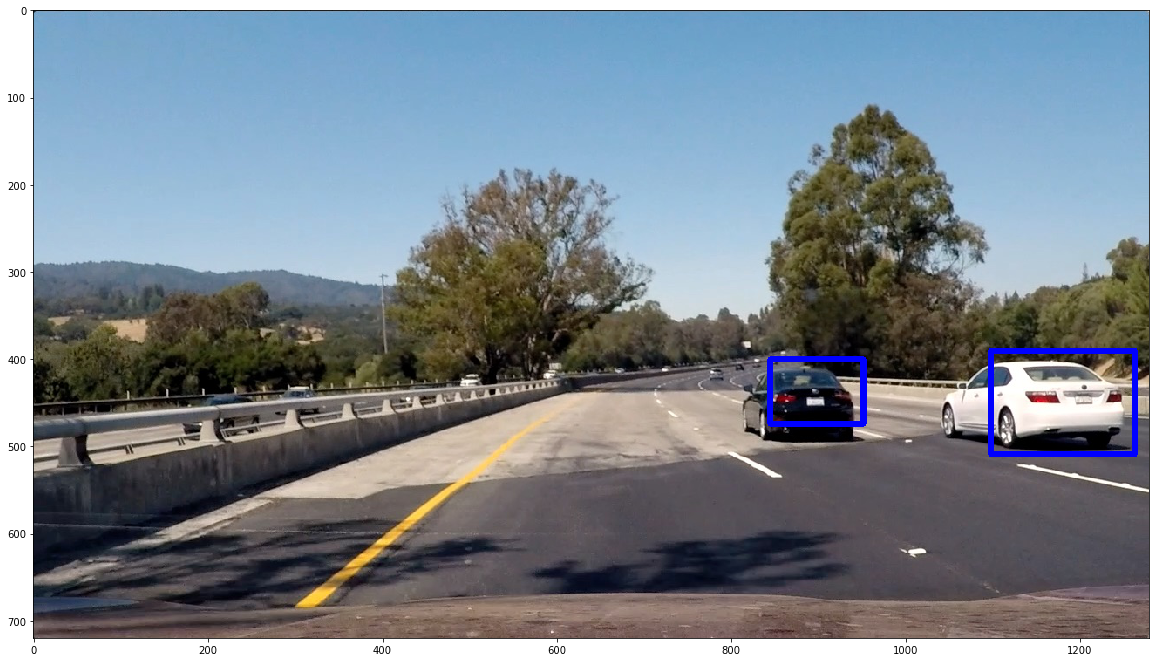

In [12]:

image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
#window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  
heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,hot_windows)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)
print(labels)
print(labels[0])
print(labels[1])

draw_img = draw_labeled_bboxes(np.copy(image), labels)
plt.figure(figsize=(20, 20))
plt.imshow(draw_img)
plt.show()

In [ ]:
def car_detect_pipeline(image, return_heatmap=False):
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float)/255.0


    windows = form_windows(image)

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

                    

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image)*255, labels)
    if return_heatmap:
        return draw_img, heatmap
    return draw_img


# Calculate Camera Calibration Parameters

In [14]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

CALIB_PARAMS='calibrate.b'
def get_camcal_parameters():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        print(fname)
        img = cv2.imread(fname)
        #print(img)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        print(ret)
        #plt.imshow(img)
        #plt.show()
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)

            cv2.waitKey(500)

    cv2.destroyAllWindows()
    return objpoints,imgpoints


In [15]:
import matplotlib.image as mpimg
def calc_mtx_dist(img,objpoints,imgpoints):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    #img=img[:,:,-1]
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    #ax1.imshow(img)
    #ax1.set_title('Original Image', fontsize=30)
    #ax2.imshow(dst)
    #ax2.set_title('Undistorted Image', fontsize=30)
    #plt.show()
    return mtx,dist,undst

def calc_calibrate_info():
    objpoints,imgpoints=get_camcal_parameters()
    img = mpimg.imread('camera_cal/calibration1.jpg')
    mtx,dist,undist=calc_mtx_dist(img,objpoints,imgpoints)
    calib_data = {'mtx':mtx,
                  'dist':dist}
    with open(CALIB_PARAMS, 'wb') as f:
        pickle.dump(calib_data, f)

calc_calibrate_info()        

camera_cal/calibration1.jpg
False
camera_cal/calibration10.jpg
True
camera_cal/calibration11.jpg
True
camera_cal/calibration12.jpg
True
camera_cal/calibration13.jpg
True
camera_cal/calibration14.jpg
True
camera_cal/calibration15.jpg
True
camera_cal/calibration16.jpg
True
camera_cal/calibration17.jpg
True
camera_cal/calibration18.jpg
True
camera_cal/calibration19.jpg
True
camera_cal/calibration2.jpg
True
camera_cal/calibration20.jpg
True
camera_cal/calibration3.jpg
True
camera_cal/calibration4.jpg
False
camera_cal/calibration5.jpg
False
camera_cal/calibration6.jpg
True
camera_cal/calibration7.jpg
True
camera_cal/calibration8.jpg
True
camera_cal/calibration9.jpg
True


## Use Camera Calibration Data to correct to raw images.

In [16]:
import cv2
import pickle
import numpy as np
import matplotlib.image as mpimg

CALIB_PARAMS='calibrate.b'

with open(CALIB_PARAMS, 'rb') as f:
    calib_data = pickle.load(f)
mtx = calib_data["mtx"]
dist = calib_data["dist"]
def undistort_img(img,mtx,dist):
    return  cv2.undistort(img, mtx, dist, None, mtx)


In [17]:
def test_undist_img(distorted_images):
    for filename in distorted_images:
        print(filename)
        img = mpimg.imread(filename)
        undist=undistort_img(img,mtx,dist)
        paths=filename.split('/')
        paths[-1]='undistort_'+paths[-1]
        undistort_filename='/'.join(paths)
        undistort_filename=undistort_filename.replace('test_images','output_images')
        cv2.imwrite(undistort_filename , undist)
        f, ( ax1,ax2) = plt.subplots(1, 2, sharey=True)
        f.set_size_inches([15., 4.])
        ax1.imshow(img)
        ax2.imshow(undist)
        plt.show()

test_images/straight_lines1.jpg


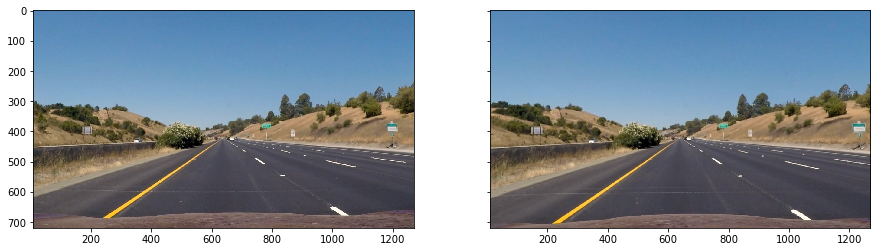

test_images/straight_lines2.jpg


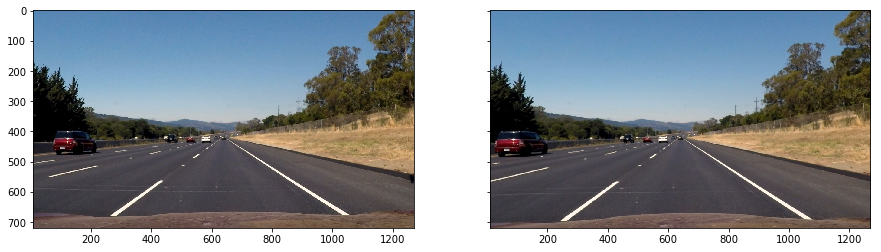

test_images/test1.jpg


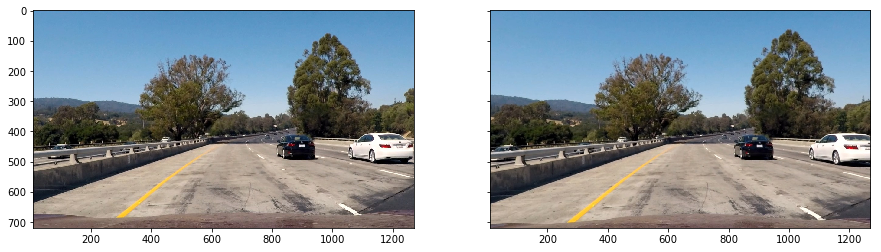

test_images/test2.jpg


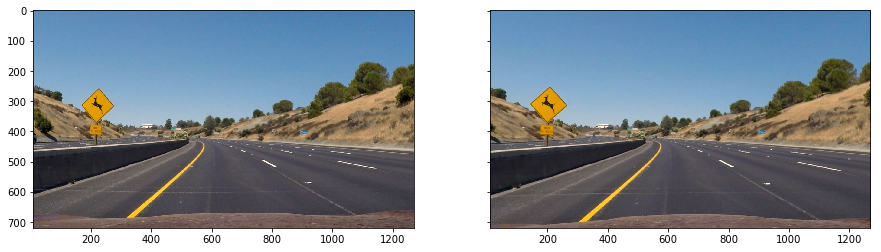

test_images/test3.jpg


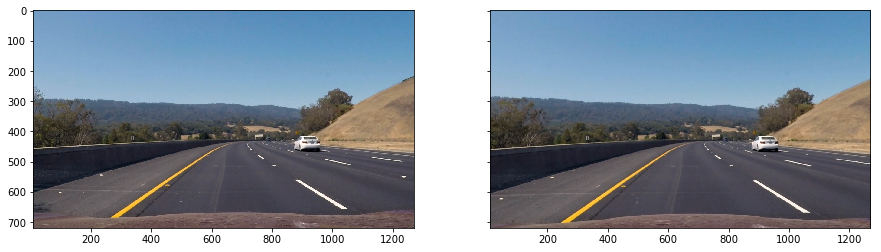

test_images/test4.jpg


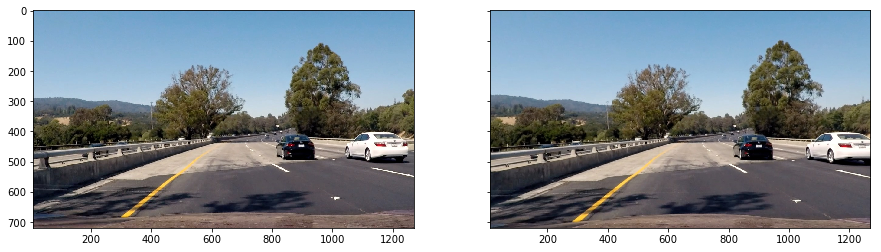

test_images/test5.jpg


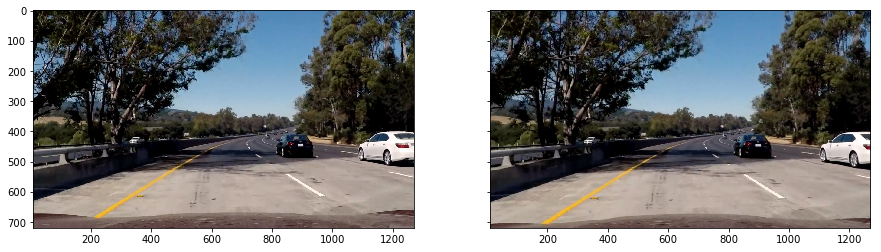

test_images/test6.jpg


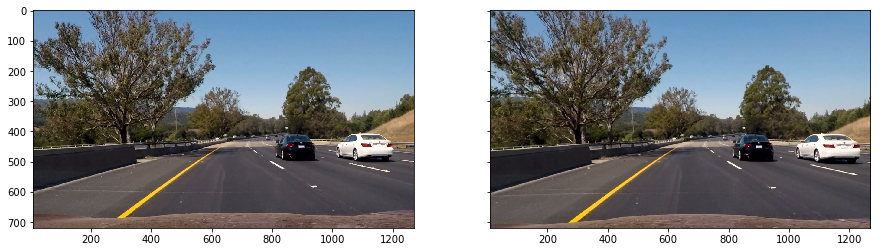

In [18]:
distorted_images = glob.glob('test_images/*.jpg')
test_undist_img(distorted_images)

## Apply a perspective transform to rectify binary image ("birds-eye view"). 

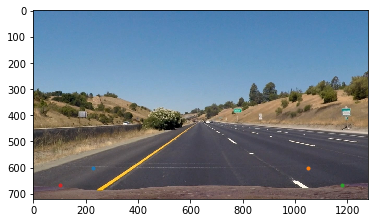

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

straight_line1_img=mpimg.imread('test_images/straight_lines1.jpg')   
plt.imshow(straight_line1_img)
plt.plot(229,600,'.')
plt.plot(1051,600,'.')
plt.plot(1180,666,'.')
plt.plot(100,666,'.')
plt.show()

In [20]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import copy

PERSPECTIVE_PARAMS='perspective.b'
def convert_bird_view(img):
    src= np.float32([[260,684],[609,441],[667,441],[1035,677]])
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
          [[229,600],
           [1051,600],
           [1180,666],
           [100,666]])
    
    dst = np.float32(
          [[img.shape[1]*0  ,img.shape[0]*0.9],
           [img.shape[1]*1  ,img.shape[0]*0.9],
           [img.shape[1]*1  ,img.shape[0]*1  ],
           [img.shape[1]*0  ,img.shape[0]*1  ]])

    #src=np.float32([[375,479],[905,479],[1811,685],[-531,685]])
    #dst=np.float32([[0,0],[500,0],[500,600],[0,600]])
    M = cv2.getPerspectiveTransform(src, dst)
    MInv = cv2.getPerspectiveTransform(dst, src)
    return M,MInv

def calc_perspective_transform():
    img=mpimg.imread('test_images/straight_lines1.jpg')                 
    M,MInv=convert_bird_view(img)
    perspective_tranform = {'M':M,'MInv':MInv}
    with open(PERSPECTIVE_PARAMS, 'wb') as f:
        pickle.dump(perspective_tranform, f)
    return M,MInv

M,MInv=calc_perspective_transform()

def perspective_transform(img,M):
    img_size=(img.shape[1],img.shape[0])
    warped_img = cv2.warpPerspective(img, M, img_size)
    return warped_img

def deperspective_transform(warped_img,MInv):
    img_size=(img.shape[1],img.shape[0])
    warped_img_inv = cv2.warpPerspective(warped_img, MInv, img_size)
    return warped_img_inv

In [21]:
def test_perspective_transform(test_filenames):
    for filename in test_filenames:
        if not filename.split('/')[-1].startswith('calibration'):

            img=mpimg.imread(filename)    
            plt.imshow(img)
            plt.show()

    for filename in test_filenames:
        if not filename.split('/')[-1].startswith('calibration'):
            img=mpimg.imread(filename)    
            img_warp = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]))
            img_warp_inv =  cv2.warpPerspective(img_warp, MInv, (img.shape[1],img.shape[0]))
            paths=filename.split('/')

            pt_paths=copy.copy(paths)
            ptinv_paths=copy.copy(paths)
            pt_paths[-1]='pt_'+pt_paths[-1]
            pt_filename='/'.join(pt_paths)
            pt_filename=pt_filename.replace('test_images','output_images')
            #print('pt file name',pt_filename)

            cv2.imwrite(pt_filename,img_warp)


            ptinv_paths[-1]='ptinv_'+ptinv_paths[-1]
            ptinv_filename='/'.join(ptinv_paths)
            #print('ptinv_filename===',ptinv_filename)
            ptinv_filename=ptinv_filename.replace('test_images','output_images')
            #print('inv file name',ptinv_filename)
            cv2.imwrite(ptinv_filename,img_warp_inv)

            f, ( ax1,ax2) = plt.subplots(1, 2, sharey=True)
            f.set_size_inches([15., 4.])
            ax1.imshow(img_warp)
            ax2.imshow(img_warp_inv)
    

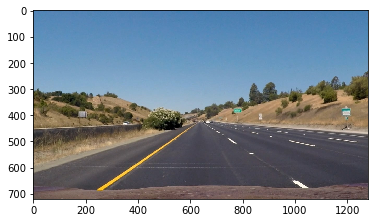

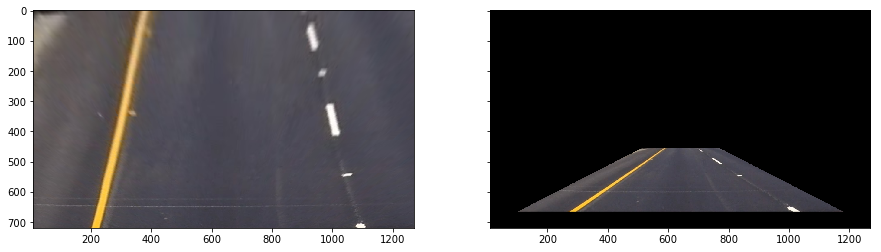

In [22]:
img=mpimg.imread('test_images/straight_lines1.jpg') 
straight_lines_1_warp =cv2.warpPerspective(img, M, (straight_line1_img.shape[1],straight_line1_img.shape[0]))
straight_lines_1_warp_inv = cv2.warpPerspective(straight_lines_1_warp, MInv, (straight_lines_1_warp.shape[1],straight_lines_1_warp.shape[0]))
plt.imshow(straight_line1_img)
plt.show()

f, ( ax1,ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches([15., 4.])
ax1.imshow(straight_lines_1_warp)
ax2.imshow(straight_lines_1_warp_inv)
    



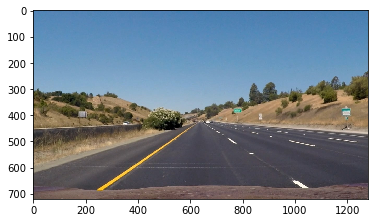

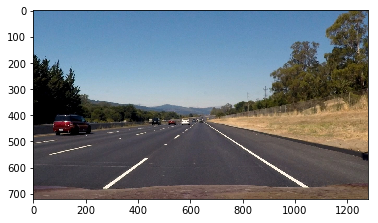

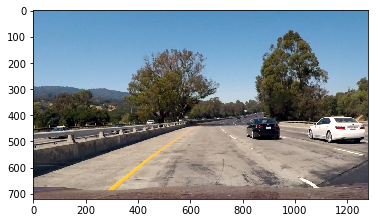

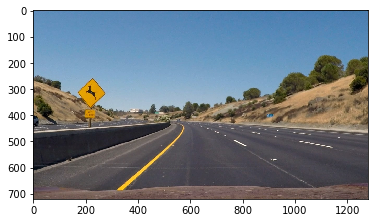

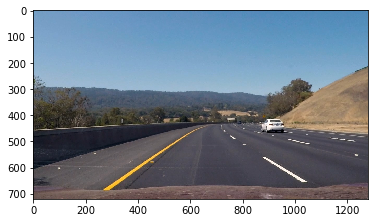

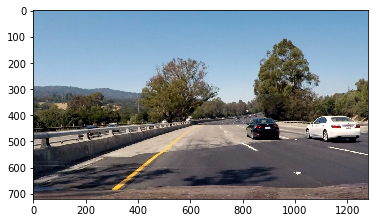

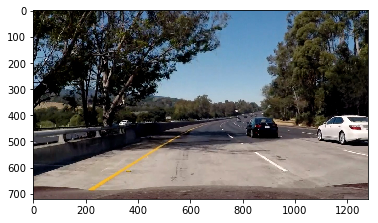

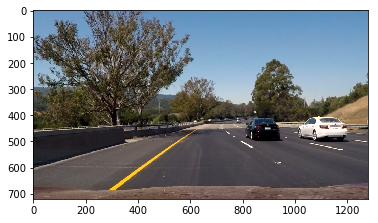

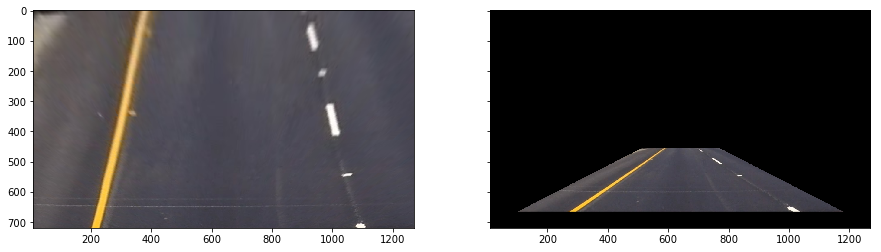

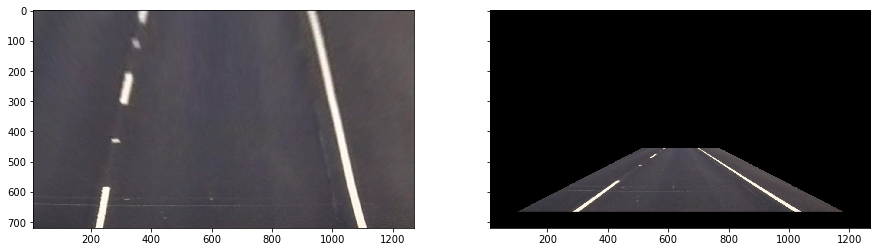

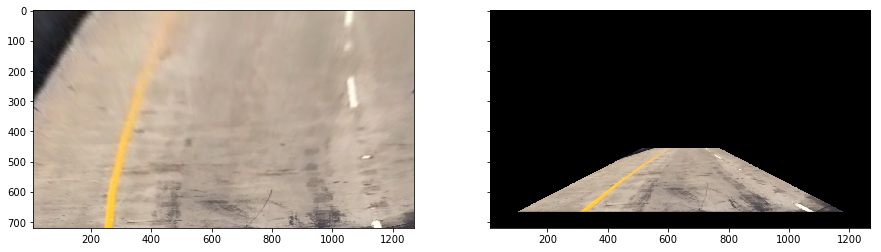

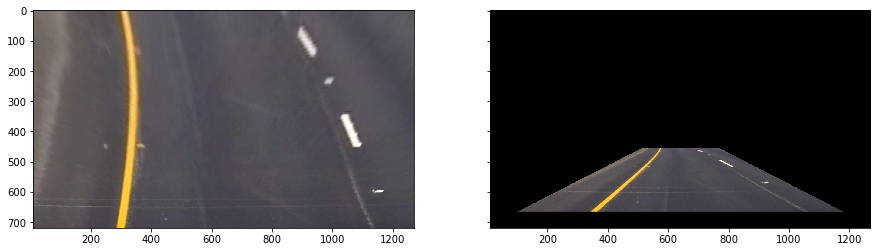

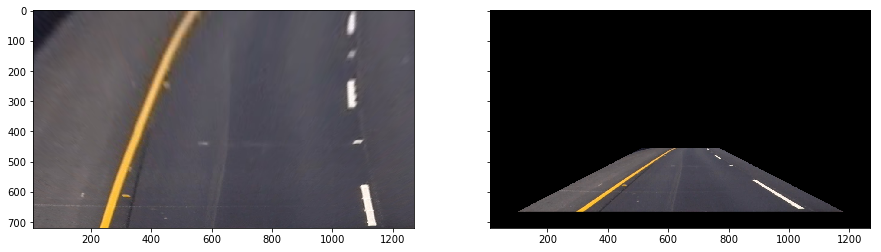

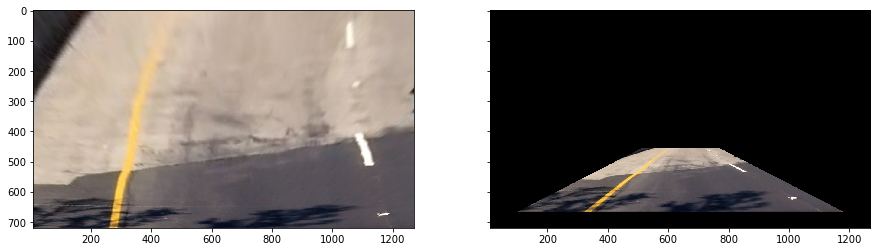

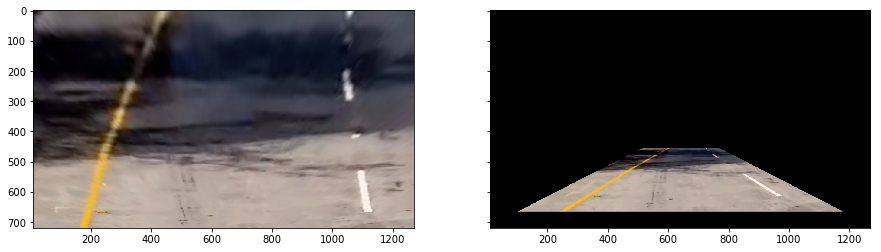

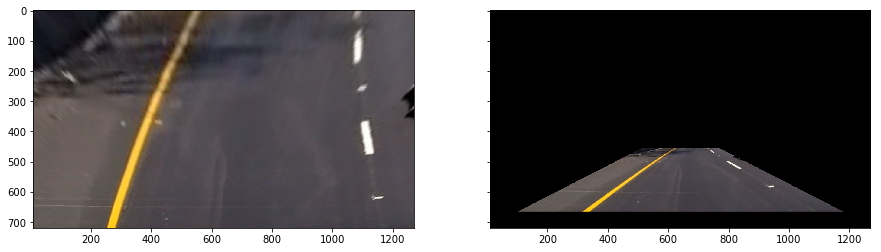

In [23]:
test_filenames = glob.glob('test_images/*.jpg')
test_perspective_transform(test_filenames)

## Use color transforms, gradients, etc., to create a thresholded binary image.

In [24]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import glob
import pickle
import matplotlib.pyplot as plt

PERSPECTIVE_PARAMS='perspective.b'
CALIB_PARAMS='calibrate.b'
def load_calibrate_paramters():
    with open(CALIB_PARAMS, 'rb') as f:
        calib_parameters = pickle.load(f)
    mtx = calib_parameters["mtx"]
    dist = calib_parameters["dist"]
    
    with open(PERSPECTIVE_PARAMS, 'rb') as f:
        perspective_parameters = pickle.load(f)
    M = perspective_parameters["M"]
    MInv = perspective_parameters["MInv"]
    return mtx,dist,M,MInv



def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    img=cv2.undistort(img, mtx, dist, None, mtx)

    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

mtx,dist,M,MInv=load_calibrate_paramters()

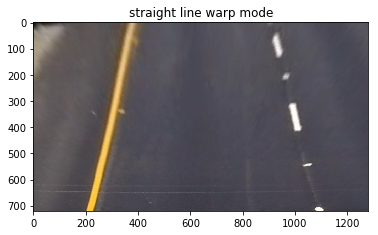

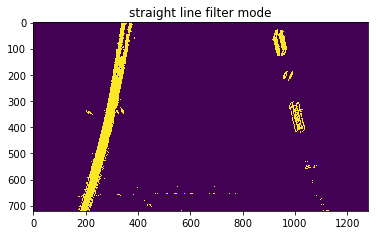

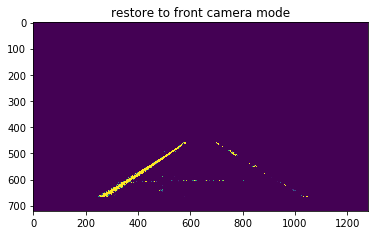

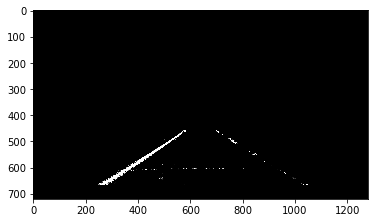

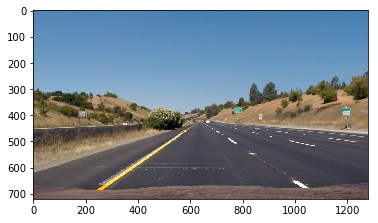

In [25]:
st_line1=mpimg.imread('test_images/straight_lines1.jpg')
st_line1_undistort= cv2.undistort(st_line1, mtx, dist, None, mtx)

st_line1_img_warp = cv2.warpPerspective(st_line1, M, (st_line1.shape[1],st_line1.shape[0]))
st_line1_img_warp_filter = pipeline(st_line1_img_warp)*255
st_line_restore =  cv2.warpPerspective(st_line1_img_warp_filter, MInv, (st_line1.shape[1],st_line1.shape[0]))
color_warp = np.dstack((st_line_restore, st_line_restore, st_line_restore))
result = cv2.addWeighted(st_line1, 1, color_warp, 0.3, 0)
cv2.imwrite('output_images/st_line_undistort.jpg',st_line1_undistort)
cv2.imwrite('output_images/st_line_warp.jpg',st_line1_img_warp)

cv2.imwrite('output_images/st_line_filter.jpg',st_line1_img_warp_filter)
cv2.imwrite('output_images/st_line_filter_rst.jpg',st_line_restore)

plt.imshow(st_line1_img_warp)
plt.title('straight line warp mode')
plt.show()



plt.imshow(st_line1_img_warp_filter)
plt.title('straight line filter mode')
plt.show()


plt.imshow(st_line_restore)

plt.title('restore to front camera mode')
plt.show()

plt.imshow(color_warp)
plt.show()

plt.imshow(result)
plt.show()

# f, ( ax1,ax2,ax3) = plt.subplots(1, 3, sharey=True)
# ax1.imshow(st_line1_img_warp)
# ax2.imshow(st_line1_img_warp_filter)
# ax3.imshow(st_line_restore)
# plt.show()

In [26]:
def test_perspective_transform_undist(image_ilenames):
    
#     for filename in image_filenames:
#         if not filename.split('/')[-1].startswith('calibration'):

#             print(filename)
#             # only undistort
#             img = mpimg.imread(filename)
#             undist=cv2.undistort(img, mtx, dist, None, mtx)
#             bin_img=pipeline(undist)
#             plt.imshow(bin_img,cmap='gray')
#             plt.show()
#     for filename in image_filenames:
#         if not filename.split('/')[-1].startswith('calibration'):
#             # perspective and de-perspective   
#             img=mpimg.imread(filename)    
#             img_warp = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]))
#             img_warp_inv =  cv2.warpPerspective(img_warp, MInv, (img.shape[1],img.shape[0]))
#             f, ( ax1,ax2) = plt.subplots(1, 2, sharey=True)
#             f.set_size_inches([15., 4.])
#             ax1.imshow(img_warp)
#             binary_image=pipeline(img_warp,s_thresh=(255,0))

#             ax2.imshow(img_warp_inv)
#             plt.show()
    
    for filename in image_filenames:
        if not filename.split('/')[-1].startswith('calibration'):

            img=mpimg.imread(filename)    
            img_warp = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]))

            f, ( ax1,ax2,ax3) = plt.subplots(1, 3, sharey=True)
            dd = pipeline(img_warp)
            img_warp_inv =  cv2.warpPerspective(dd, MInv, (img.shape[1],img.shape[0]))

            color_warp = np.dstack((img_warp_inv, img_warp_inv, img_warp_inv))
            result = cv2.addWeighted(img, 1, color_warp, 0.3, 0)
            ax1.imshow(img)
            ax2.imshow(dd)
            ax3.imshow(img_warp_inv)
            plt.show()

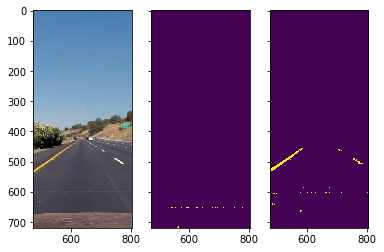

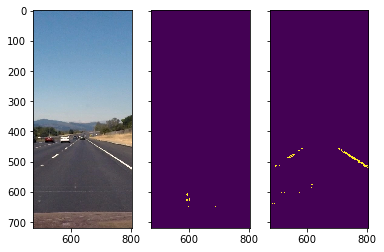

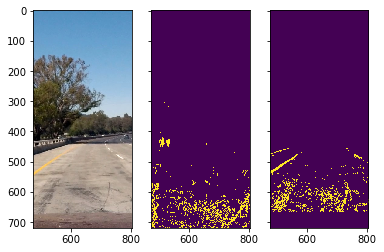

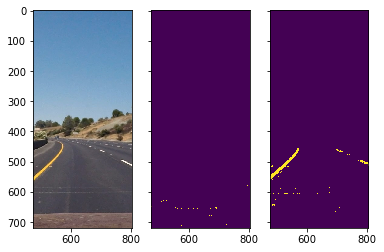

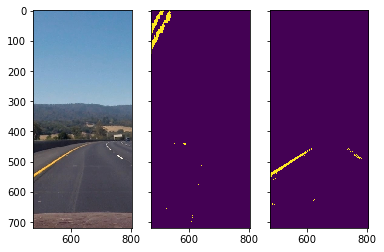

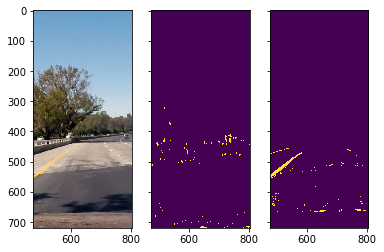

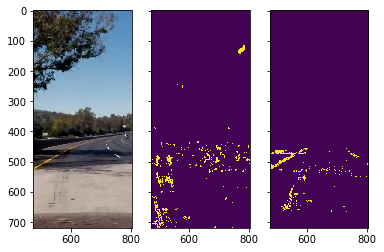

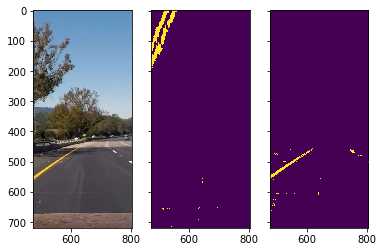

In [27]:
image_filenames = glob.glob('test_images/*.jpg')
test_perspective_transform_undist(image_filenames)

## Find starting point through histogram

In [28]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import glob
import pickle
import matplotlib.pyplot as plt
from collections import deque


PERSPECTIVE_PARAMS='perspective.b'
CALIB_PARAMS='calibrate.b'

QUEUE_LENGTH=9

left_fit_size=0
right_fit_size=0
right_fit_history=deque(QUEUE_LENGTH*[np.zeros(3,)],QUEUE_LENGTH)
left_fit_history=deque(QUEUE_LENGTH*[np.zeros(3,)],QUEUE_LENGTH)
def reset_fit_parametrs():
    global right_fit_size
    global left_fit_size
    global right_fit_history
    global left_fit_history
    right_fit_history=deque(QUEUE_LENGTH*[np.zeros(3,)],QUEUE_LENGTH)
    left_fit_history=deque(QUEUE_LENGTH*[np.zeros(3,)],QUEUE_LENGTH)
    left_fit_size=0
    right_fit_size=0
def load_calibrate_paramters():
    with open(CALIB_PARAMS, 'rb') as f:
        calib_parameters = pickle.load(f)
    mtx = calib_parameters["mtx"]
    dist = calib_parameters["dist"]
    
    with open(PERSPECTIVE_PARAMS, 'rb') as f:
        perspective_parameters = pickle.load(f)
    M = perspective_parameters["M"]
    MInv = perspective_parameters["MInv"]
    return mtx,dist,M,MInv

mtx,dist,M,MInv=load_calibrate_paramters()
def get_curve(ploty,left_fitx,right_fitx,left_fit, right_fit):

    y_eval = 719

    # x,y scale for per pix
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/980 # meters per pixel
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Transform
#     right_fit_cr = ym_per_pix * np.array((right_fit[0]*xm_per_pix*xm_per_pix,right_fit[1]*xm_per_pix),right_fit[2])
#     left_fit_cr = ym_per_pix * np.array((left_fit[0]*xm_per_pix*xm_per_pix,left_fit[1]*xm_per_pix),left_fit[2])
                               
#     # Calculate the new radii of curvature
#     left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit[0])
#     right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit[0])
  
    # Calculate a polinomial value in a given point x

    left_pos = np.poly1d(left_fit)(720)
    right_pos = np.poly1d(right_fit)(720)
    #print(left_pos,right_pos)
    center_pos = (left_pos + right_pos)/2
    #print(center_pos)
    center_offset = center_pos - (1280/2)
    #print(center_offset)
    center_offset_scale =xm_per_pix # .00431 
    center_offset_m = center_offset * center_offset_scale

    #print('center_offset_m===',center_offset_m)


    return left_curverad,right_curverad
    
    


def find_line(binary_warped,b_video=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    global left_fit
    global right_fit

    #left_fit = None
    #right_fit = None
    smoothing=0.75

    if not 'left_fit' in globals():
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        #print('smoothing===',smoothing)
        #print('left_fit===',left_fit)
        ##print('lefty===',lefty)
        #print('leftx===',leftx)
        if len(lefty)>0 and len(leftx)>=0:
            left_fit = (smoothing)*left_fit   + ((1-smoothing)*np.polyfit(lefty, leftx, 2))
    
    if not 'right_fit' in globals():
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = (smoothing)*right_fit + ((1-smoothing)*np.polyfit(righty, rightx, 2))


    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except:
        pass
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    if b_video:
        global right_fit_size
        global left_fit_size
        global right_fit_history
        global left_fit_history
        left_curve,right_curve=get_curve(ploty,left_fitx,right_fitx,left_fit,right_fit)
        if((left_curve>200)&(int(left_curve)<10000)):
            left_fit_size=left_fit_size+1
            left_fit_history.append(left_fit)
        if(left_fit_size>=7):
            left_fit=np.mean(left_fit_history,axis=0)
        
        if((right_curve>200)&(int(right_curve)<10000)):
            right_fit_size=right_fit_size+1
            right_fit_history.append(right_fit)
        if(right_fit_size>=7):
            right_fit=np.mean(right_fit_history,axis=0)
            #right_fit=right_fit_history[QUEUE_LENGTH-1]           
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    margin  *= 0.5
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 0,255))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (255,0,0))
    
    cv2.floodFill(image = window_img, seedPoint = (window_img.shape[1]//2-1,window_img.shape[0]-1), newVal=(0,255, 0), loDiff=(0, 0, 0, 0), upDiff=(0, 0, 0, 0), flags=4, mask=None)
    #print(left_fit)
    #print(right_fit)

    #plt.imshow(window_img)
    plt.show()
    return window_img,left_fit,right_fit,ploty,left_fitx,right_fitx


In [29]:

def calc_radius(img,ploty,left_fitx,right_fitx,left_fit, right_fit):

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = 719

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/980 # meters per pixel in x dimension
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

#     # Transform
#     right_fit_cr = ym_per_pix * np.array((right_fit[0]*xm_per_pix*xm_per_pix,right_fit[1]*xm_per_pix),right_fit[2])
#     left_fit_cr = ym_per_pix * np.array((left_fit[0]*xm_per_pix*xm_per_pix,left_fit[1]*xm_per_pix),left_fit[2])
                               
#     # Calculate the new radii of curvature
#     left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit[0])
#     right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit[0])
#     # Now our radius of curvature is in meters
#     # print(left_curverad, 'm', right_curverad, 'm')
#     # Example values: 632.1 m    626.2 m
    
    # Calculate a polinomial value in a given point x

    left_pos = np.poly1d(left_fit)(720)
    right_pos = np.poly1d(right_fit)(720)
    #print(left_pos,right_pos)
    center_pos = (left_pos + right_pos)/2
    #print(center_pos)
    center_offset = center_pos - (1280/2)
    #print(center_offset)
    center_offset_scalefactor = .00431 
    center_offset_m = center_offset * center_offset_scalefactor

    #print('center_offset_m===',center_offset_m)
    #print('left_curverad=====',left_curverad )
    #print('right_curverad=====',right_curverad )

    #print(((left_curverad + right_curverad)/2))
    
    cv2.putText(img,'offset: %.2fm' % (center_offset_m),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    cv2.putText(img,'radius: %.2fm' % ((left_curverad + right_curverad)/2),(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
   




In [30]:



def merge_imgs(img,ploty,left_fitx,right_fitx,warped,left_fit,right_fit):
 
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warped, MInv, (warped.shape[1], warped.shape[0]))
    #newwarp[:newwarp.shape[0]//4,:,:] = 0
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    calc_radius(result,ploty,left_fitx,right_fitx,left_fit,right_fit)
    #plt.imshow(result)
    return result

  

In [34]:
window_width = 40 
window_height = 250 # Break image into 9 vertical layers since image height is 720
margin = 50 # How much to slide left and right for searching

poly_left = []
poly_right = []

def get_curverad(coef, y):
    return ((1 + (2*coef[0]*y + coef[1])**2)**1.5) / np.abs(2*coef[0])

bVideo=False

def process_image(img):
    global poly_left
    global poly_right
    #plt.plot(img)
    #plt.show()
    img_size = (img.shape[1], img.shape[0])
    # Undistort image
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(undistorted, M, img_size)
    b_warped=pipeline(warped)
    window_line,left_fit,right_fit,ploty,left_fitx,right_fitx=find_line(b_warped,bVideo)
    result=merge_imgs(img,ploty,left_fitx,right_fitx,window_line,left_fit,right_fit)
    result=car_detect_pipeline(result)
    return result,undistorted,warped,b_warped

In [35]:
bVideo=False
def test_find_lines(image_filenames):
    for filename in image_filenames:
        if not filename.split('/')[-1].startswith('calibration'):

            print(filename)

            img = mpimg.imread(filename)
            reset_fit_parametrs()
            processed_img=process_image(img)[0]
            paths=filename.split('/')
            paths[-1]='lane_'+paths[-1]
            lane_filename='/'.join(paths)
            #print('ptinv_filename===',ptinv_filename)
            lane_filename=lane_filename.replace('test_images','output_images')
            #print('inv file name',ptinv_filename)
            cv2.imwrite(lane_filename,processed_img)
            plt.imshow(processed_img)
            plt.show()

test_images/straight_lines1.jpg


/Users/hubing/anaconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


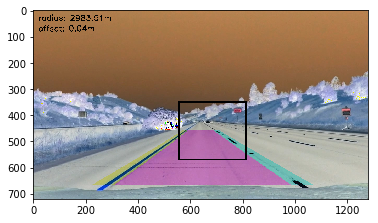

test_images/straight_lines2.jpg


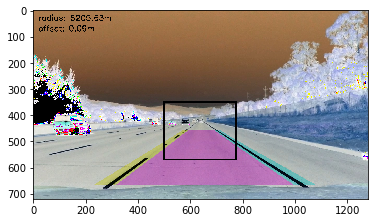

test_images/test1.jpg


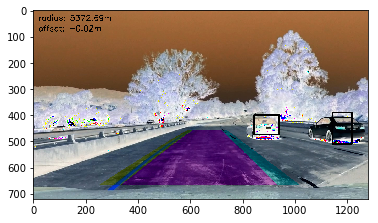

test_images/test2.jpg


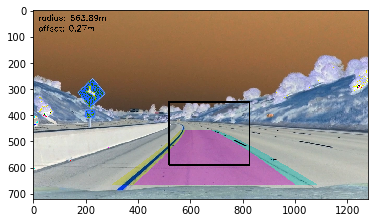

test_images/test3.jpg


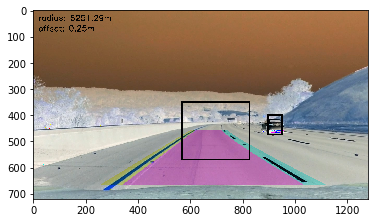

test_images/test4.jpg


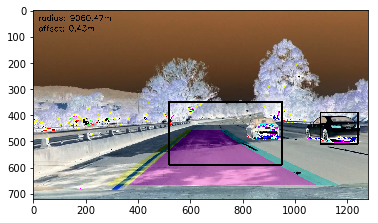

test_images/test5.jpg


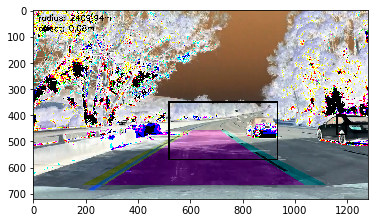

test_images/test6.jpg


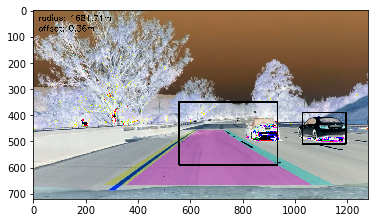

In [36]:

image_filenames = glob.glob('test_images/*.jpg')

test_find_lines(image_filenames)

# Run Against Testing Video

In [37]:
import imageio
imageio.plugins.ffmpeg.download()


In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
bVideo=True
reset_fit_parametrs()
white_output = 'processed_video_project.mp4'

clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(lambda img: process_image(img)[0])
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video processed_video_project.mp4
[MoviePy] Writing video processed_video_project.mp4


 19%|█▉        | 239/1261 [01:27<06:10,  2.76it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## And so on and so forth...